# Show fringe correction improvement on point source integrated spectrum

### Define path to data and set flags

### <font color='green'> --Modify following path to the folder where the miri_mrs_point_source_fringes folder resides </font>

In [1]:
user_dir = '/Users/ioannisa/Desktop/python/miri_mrs_point_source_fringes/'

### <font color='green'> --Choose if you wish to save plots (default is True) </font>

In [2]:
save_plots = True

### <font color='red'> --Do NOT change following paths </font>

In [3]:
datapath   = user_dir+'data/'
figurepath = user_dir+'figures/'
outputpath = user_dir+'output_files/'

In [4]:
import itertools
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

import sys
sys.path.append(user_dir)
from core.funcs import detpixel_trace,detpixel_isolambda

In [5]:
%matplotlib notebook

### Preamble

### --MRS auxilliary data

In [6]:
band = '1A'
nslices = 21

### --Load distortion maps

In [7]:
d2cMaps = {'sliceMap':np.load(datapath+'sliceMap.npy'),
           'lambdaMap':np.load(datapath+'lambdaMap.npy'),
           'alphaMap':np.load(datapath+'alphaMap.npy'),
           'betaMap':np.load(datapath+'betaMap.npy'),
           'nslices':nslices}

### --Load data

In [8]:
sci_img        = fits.open(datapath+'CV2_P0.fits')[1].data
fringe_flat    = np.load(datapath+'fringe_flat.npy')
spectral_response = np.load(datapath+'spectral_response.npy')

### --Apply spectral response correction

In [9]:
sci_img /= spectral_response

### --Load point source fringe flat from notebook 4

In [10]:
ps_fringe_flat = np.load(outputpath+'ps_fringe_flat.npy')

### Spectral analysis

### --Define spectral grid

In [11]:
ypos,xpos = detpixel_trace(band,d2cMaps,sliceID=int(nslices/2),alpha_pos=0.)
wav_array = d2cMaps['lambdaMap'][ypos,xpos]

### --Initialize placeholders

In [12]:
integrated_spectrum_no_correction  = np.zeros(len(ypos))
integrated_spectrum_fringe_flat    = np.zeros(len(ypos))
integrated_spectrum_ps_fringe_flat = np.zeros(len(ypos))

### --Produce calibrated datasets

In [13]:
cal_img_no_correction  = sci_img.copy()
cal_img_fringe_flat    = sci_img/fringe_flat
cal_img_ps_fringe_flat = sci_img/ps_fringe_flat

### --Compute an integrate spectrum

In [14]:
for i,wav in enumerate(wav_array):
    if i == int(len(wav_array)/2):
        print('Halfway there..')
    valid_img = np.zeros((1024,1032))
    for sliceID in range(1,nslices+1):
        try:
            ypos,xpos = detpixel_isolambda(band,d2cMaps,sliceID=sliceID,lambda_pos=wav)
        except IndexError:
            continue
        valid_img[ypos,xpos] = 1
    
    integrated_spectrum_no_correction[i]  = np.sum(( cal_img_no_correction *valid_img)[~np.isnan(cal_img_no_correction)])
    integrated_spectrum_fringe_flat[i]    = np.sum(( cal_img_fringe_flat *valid_img)[~np.isnan(cal_img_fringe_flat)])
    integrated_spectrum_ps_fringe_flat[i] = np.sum(( cal_img_ps_fringe_flat *valid_img)[~np.isnan(cal_img_ps_fringe_flat)])
print('DONE')

Halfway there..
DONE


### --Plot fringe correction comparison

<IPython.core.display.Javascript object>


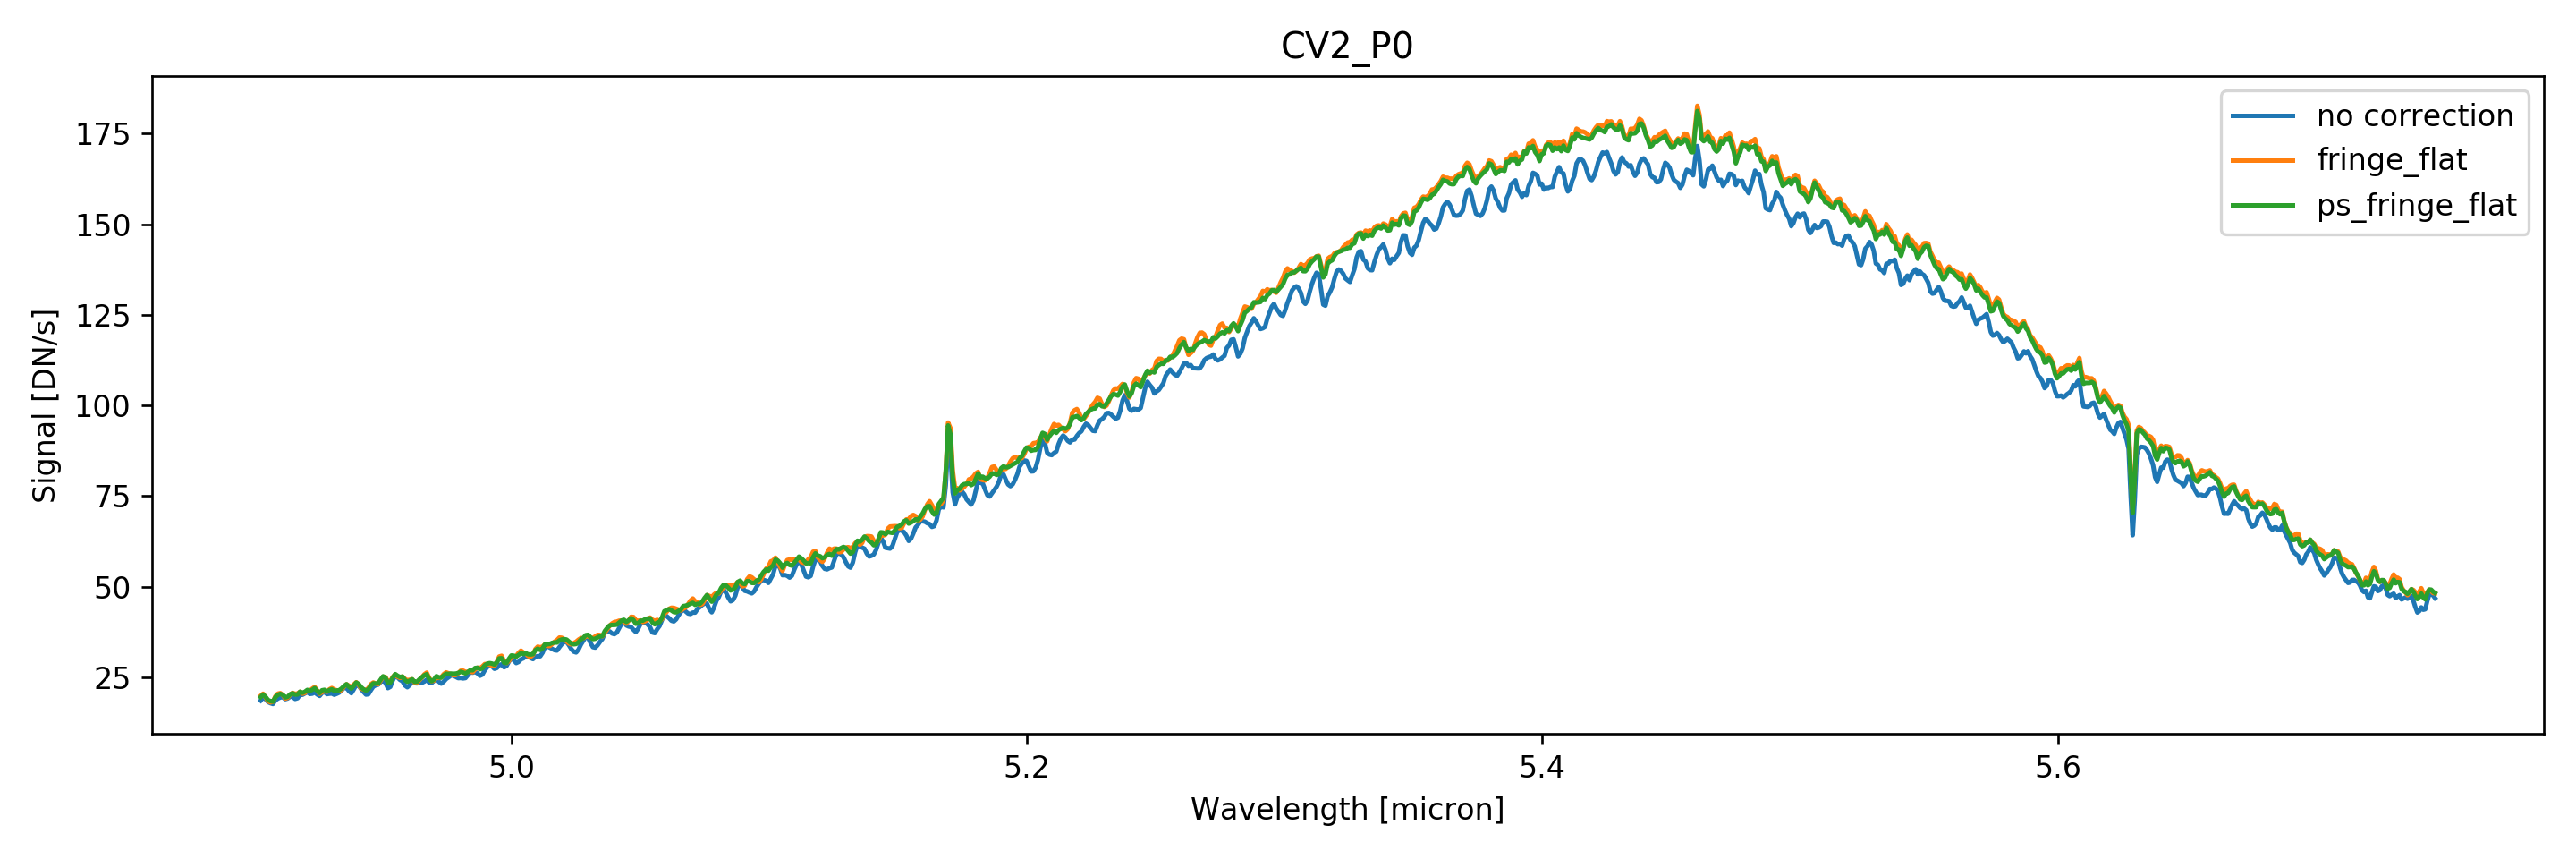

In [15]:
plt.figure(figsize=(12,4))
plt.plot(wav_array[20:-20],integrated_spectrum_no_correction[20:-20],label='no correction')
plt.plot(wav_array[20:-20],integrated_spectrum_fringe_flat[20:-20],label='fringe_flat')
plt.plot(wav_array[20:-20],integrated_spectrum_ps_fringe_flat[20:-20],label='ps_fringe_flat')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Signal [DN/s]')
plt.title('CV2_P0')
plt.legend()
plt.tight_layout()

### --Smooth the remaining signal to try to estimate the residual fringes

<IPython.core.display.Javascript object>


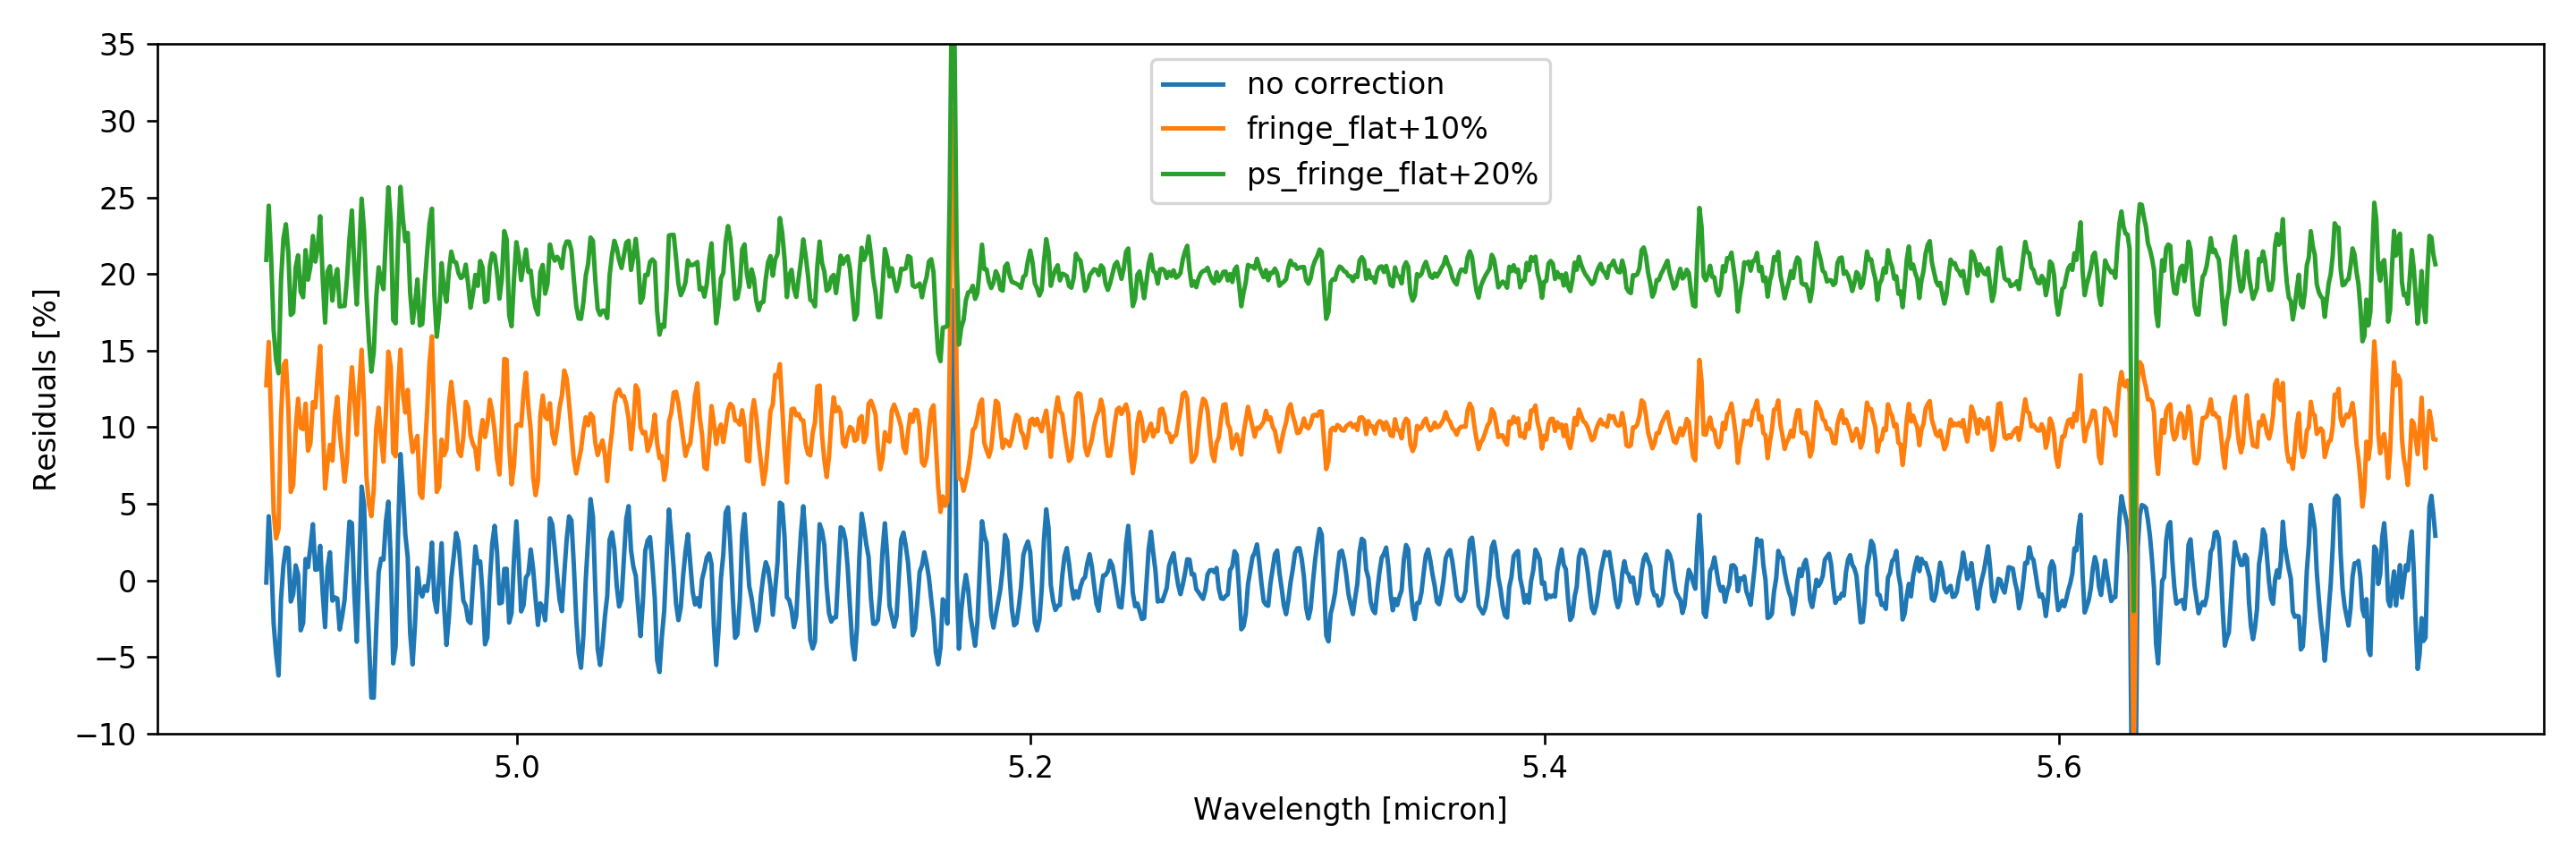

Standard deviation - no correction: 2.5 %
Standard deviation - fringe_flat: 2.03 %
Standard deviation - ps_fringe_flat: 1.93 %


In [16]:
residuals_no_correction  = 100*((integrated_spectrum_no_correction/gaussian_filter(integrated_spectrum_no_correction,5))-1)
residuals_fringe_flat    = 100*((integrated_spectrum_fringe_flat/gaussian_filter(integrated_spectrum_fringe_flat,5))-1)
residuals_ps_fringe_flat = 100*((integrated_spectrum_ps_fringe_flat/gaussian_filter(integrated_spectrum_ps_fringe_flat,5))-1)

plt.figure(figsize=(12,4))
plt.plot(wav_array[20:-20],residuals_no_correction[20:-20],label='no correction',zorder=0)
plt.plot(wav_array[20:-20],residuals_fringe_flat[20:-20]+10,label='fringe_flat+10%',zorder=1)
plt.plot(wav_array[20:-20],residuals_ps_fringe_flat[20:-20]+20,label='ps_fringe_flat+20%',zorder=2)
plt.ylim(-10,35)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Residuals [%]')
plt.legend()
plt.tight_layout()

print('Standard deviation - no correction: {} %'.format( round(np.std(residuals_no_correction[20:-20]),2) ))
print('Standard deviation - fringe_flat: {} %'.format( round(np.std(residuals_fringe_flat[20:-20]),2) ))
print('Standard deviation - ps_fringe_flat: {} %'.format( round(np.std(residuals_ps_fringe_flat[20:-20]),2) ))